<a href="https://colab.research.google.com/github/Dforouzanfar/ML_Unimi_2024/blob/master/muffin_chihuahua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
from timeit import default_timer as timer
!pip install torchinfo
import torchinfo
from torchinfo import summary

In [21]:
# Download helper functions
request = requests.get("https://raw.githubusercontent.com/Dforouzanfar/ML_Unimi_2024/master/Helper_Functions.py")
with open("helper_functions.py", "wb") as f:
  f.write(request.content)

from helper_functions import train_step, test_step, train, plot_loss_curves, walk_through_dir, pred_and_plot_image

In [3]:
# If you want to download the dataset, you should insert your own credentials.

os.environ['KAGGLE_USERNAME'] = "**"
os.environ['KAGGLE_KEY'] = "**"

In [4]:
# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "muffin_chihuahua"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  pass
else:
  image_path.mkdir(parents=True, exist_ok=True)

# Download dataset
os.chdir(data_path)
!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

os.chdir("/content/")
with zipfile.ZipFile("/content/data/muffin-vs-chihuahua-image-classification.zip", "r") as zip_ref:
  print("Unzipping")
  zip_ref.extractall(image_path)

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification
License(s): CC0-1.0
 96% 457M/474M [00:06<00:00, 87.1MB/s]
100% 474M/474M [00:06<00:00, 81.0MB/s]
Unzipping


In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# using walk_through_dir function from helper_functions
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/muffin_chihuahua'.
There are 2 directories and 0 images in 'data/muffin_chihuahua/train'.
There are 0 directories and 2559 images in 'data/muffin_chihuahua/train/chihuahua'.
There are 0 directories and 2174 images in 'data/muffin_chihuahua/train/muffin'.
There are 2 directories and 0 images in 'data/muffin_chihuahua/test'.
There are 0 directories and 640 images in 'data/muffin_chihuahua/test/chihuahua'.
There are 0 directories and 544 images in 'data/muffin_chihuahua/test/muffin'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/muffin_chihuahua/train'),
 PosixPath('data/muffin_chihuahua/test'))

In [8]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

In [9]:
# All the transforms:

# Create a transform
data_transform = transforms.Compose([
  # Resize our images to 64*64
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

# Create simple transform
simple_transform = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  transforms.ToTensor()
])

# Create training transform with TriviailAugment
trivial_transform = transforms.Compose([
                                               transforms.Resize(size=(64, 64)),
                                               transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                               transforms.ToTensor()
])

# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
                                             transforms.Resize(size=(64, 64))
])

In [10]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

In [11]:
# Get class names
class_names, class_dict = train_data.classes, train_data.class_to_idx
class_names, class_dict

(['chihuahua', 'muffin'], {'chihuahua': 0, 'muffin': 1})

In [12]:
# Turn train and test datasets into DataLoader's
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78c40523ead0>,
 <torch.utils.data.dataloader.DataLoader at 0x78c40523e1a0>)

In [13]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, # 53 if 224
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [14]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=2, bias=True)
  )
)

In [17]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 10

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
start_time = timer()

# Train model 1
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0 | Train loss: 0.6918 | Train acc: 0.5371 | Test loss: 0.6899 | Test acc: 0.5405
Epoch: 1 | Train loss: 0.6902 | Train acc: 0.5407 | Test loss: 0.6900 | Test acc: 0.5405
Epoch: 2 | Train loss: 0.6902 | Train acc: 0.5407 | Test loss: 0.6899 | Test acc: 0.5405
Epoch: 3 | Train loss: 0.6901 | Train acc: 0.5407 | Test loss: 0.6902 | Test acc: 0.5405
Epoch: 4 | Train loss: 0.6901 | Train acc: 0.5407 | Test loss: 0.6899 | Test acc: 0.5405
Epoch: 5 | Train loss: 0.6902 | Train acc: 0.5407 | Test loss: 0.6899 | Test acc: 0.5405
Epoch: 6 | Train loss: 0.6901 | Train acc: 0.5407 | Test loss: 0.6901 | Test acc: 0.5405
Epoch: 7 | Train loss: 0.6901 | Train acc: 0.5407 | Test loss: 0.6899 | Test acc: 0.5405
Epoch: 8 | Train loss: 0.6901 | Train acc: 0.5407 | Test loss: 0.6899 | Test acc: 0.5405
Epoch: 9 | Train loss: 0.6902 | Train acc: 0.5407 | Test loss: 0.6900 | Test acc: 0.5405
Total training time for model_1: 587.554 seconds


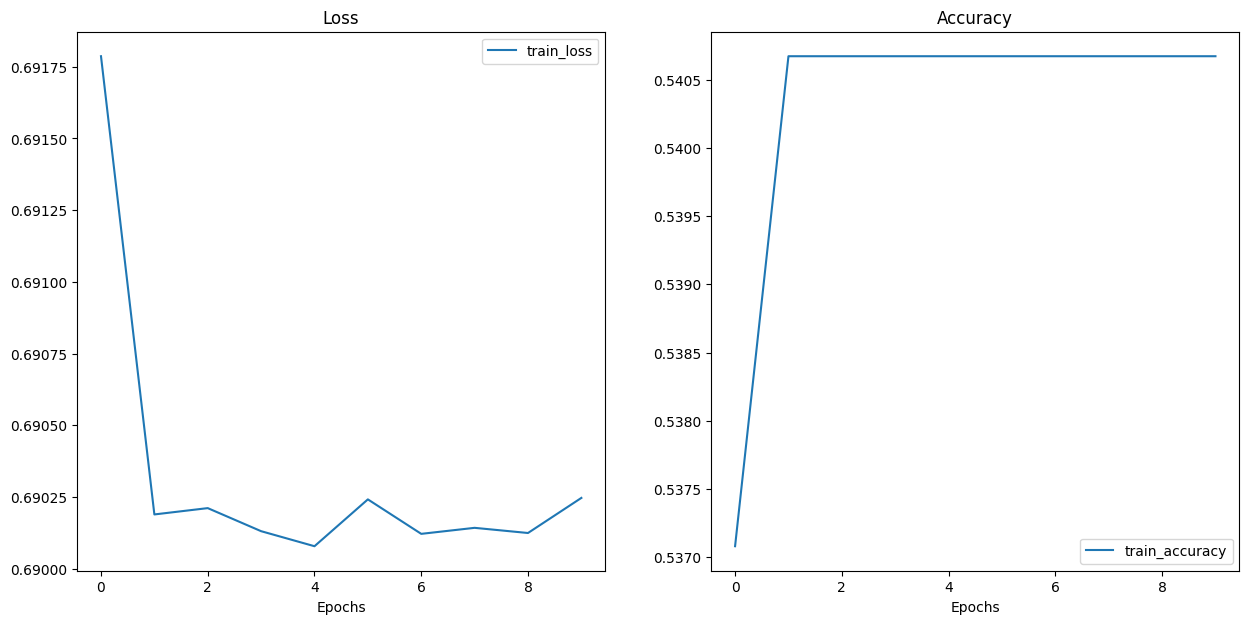

In [18]:
plot_loss_curves(model_0_results)

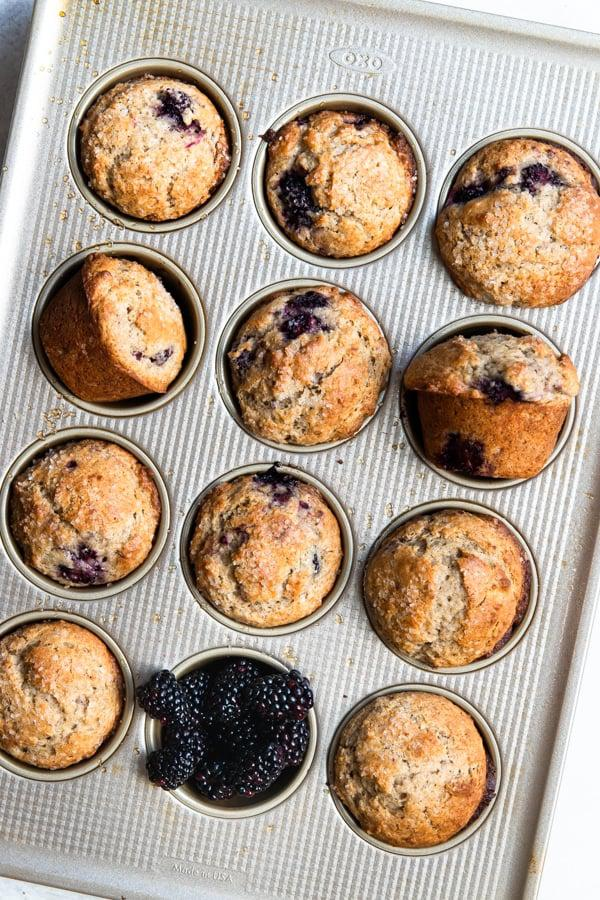

In [19]:
random.seed(20)
custom_image_path = random.choice(image_path_list)
Image.open(custom_image_path)

In [22]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

NameError: name 'torchvision' is not defined